# Importing Required Libraries 

In [5]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from os import listdir, getcwd
from os.path import isfile, join, basename
from pmdarima import auto_arima
from tqdm import tqdm
from zipfile import ZipFile
from typing import Awaitable
import asyncio
import skillsnetwork
import numpy as np
import pandas as pd
import glob
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
def warn(*args, **kwargs):
    pass # Suppress warnings generated by your code
warnings.warn = warn
warnings.filterwarnings('ignore')

# Dataset

https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0R8TEN/labs/data/cryptocurrency.zip

# Defining Helper Functions

In [4]:
def read_date_series_files(files, strat_time, end_time, join_type, col_read=None):
    folder = glob.glob(files)  # get files name
    dfs = pd.DataFrame(pd.date_range(start=strat_time, end=end_time, freq="d"), columns=["Date"])

    if join_type == "left":  # combine different columns from different files
        for f in folder:
            df = pd.read_csv(f, sep=",", header=0, usecols=col_read)
            df["Date"] = pd.to_datetime(df["Date"])
            dfs = dfs.merge(df, how=join_type, left_on="Date", right_on="Date")
            dfs.set_axis([*dfs.columns[:-1], basename(f).replace(".csv", "")], axis=1, inplace=True)
    elif join_type == "normal":  # combine same columns from different files
        df = [pd.read_csv(f, sep=",", header=0, usecols=col_read) for f in folder]
        dfs = pd.concat(df, ignore_index=True)
        dfs["Date"] = pd.to_datetime(dfs["Date"])

    dfs.set_index("Date", inplace=True)  # make the date become the index
    dfs = dfs.sort_index()
    return dfs


def find_first_date(df, display=False):
    global start_date, end_date
    i = df.isnull().sum().max()
    start_date = df.index[i]
    end_date = df.index[-1]
    if display:
        print("The first date in this time series is: ", start_date, "\n The last date in this time series is: ", end_date)


def clean_data(tv, pv):
    df1, df2 = tv.copy(), pv.copy()
    
    find_first_date(tv, True)
    df1 = df1[start_date:]

    df2 = df2[start_date:]
    df2.drop(["4 Mo"], axis=1, inplace=True)
    # fill missing datetime with previous day's values
    df2 = df2.reindex(pd.date_range(start_date, end_date)).reset_index().rename(columns={"index": "Date"})
    df2 = df2.groupby(df2["Date"].dt.time).ffill()
    df2.set_index("Date", inplace=True)
    return df1, df2


def prepare_data(dataset):
    df = dataset.copy()
    
    # normalized the data with min-max scaling
    df_nor = pd.DataFrame(MinMaxScaler().fit_transform(df)).assign(label=df.index)
    df_nor.columns = df.columns.to_list() + ["Date"]
    df_nor.set_index("Date", inplace=True)
    
    # we will remove the weak corellation (% between -0.2 to 0.2)
    cor = df_nor.corr(method="pearson")
    df_nor.drop(df_nor.columns[(cor.Index >= -0.2) & (cor.Index <= 0.2)], axis=1, inplace=True)
    return df_nor


def time_series_split(df, train_percent):
    train_size = int(len(df) * train_percent)
    predictor_train, target_train = pd.DataFrame(df.iloc[:train_size, :-1]), pd.DataFrame(df.iloc[:train_size, -1])
    predictor_test, target_test = pd.DataFrame(df.iloc[train_size:, :-1]), pd.DataFrame(df.iloc[train_size:, -1])
    return predictor_train, predictor_test, target_train, target_test


def decompose(df, period):
    decomposition = seasonal_decompose(df, model="additive", period=period)

    fig, axs = plt.subplots(4, 1, figsize=(18, 18))
    # original time series
    axs[0].plot(decomposition.observed)
    axs[0].set_title("Original Series", size=15)
    axs[0].xaxis.set_major_locator(plt.MaxNLocator(7))
    # trend
    axs[1].plot(decomposition.trend)
    axs[1].set_title("Trend", size=15)
    axs[1].xaxis.set_major_locator(plt.MaxNLocator(7))
    # seasonal
    axs[2].plot(decomposition.seasonal)
    axs[2].set_title("Seasonal", size=15)
    axs[2].xaxis.set_major_locator(plt.MaxNLocator(7))
    # residual
    axs[3].plot(decomposition.resid)
    axs[3].set_title("Residual", size=15)
    axs[3].xaxis.set_major_locator(plt.MaxNLocator(7))
    plt.show()


def stationary(df):
    ori_df = df  # original time series
    fir_df = df.diff().dropna()  # first difference time series
    sec_df = df.diff().diff().dropna()  # second difference time series
    stationary_test = None

    fig, axs = plt.subplots(3, 3, figsize=(21, 9))
    for i in range(3):
        if i == 0:
            print("Original Time Series")
            stationary_test = adfuller(ori_df)
            axs[i, 0].plot(ori_df)
            axs[i, 0].set_title("Original Time Series")
            axs[i, 0].label_outer()
            plot_acf(ori_df, ax=axs[i, 1])
            plot_pacf(ori_df, ax=axs[i, 2])
        elif i == 1:
            print("First Order Differencing")
            stationary_test = adfuller(fir_df)
            axs[i, 0].plot(fir_df)
            axs[i, 0].set_title("First Order Differencing")
            axs[i, 0].label_outer()
            plot_acf(fir_df, ax=axs[i, 1])
            plot_pacf(fir_df, ax=axs[i, 2])
        elif i == 2:
            print("Second Order Differencing")
            stationary_test = adfuller(sec_df)
            axs[i, 0].plot(sec_df)
            axs[i, 0].set_title("Second Order Differencing")
            axs[i, 0].label_outer()
            plot_acf(sec_df, ax=axs[i, 1])
            plot_pacf(sec_df, ax=axs[i, 2])

        print("ADF Statistic: %f" %stationary_test[0])
        print("p-value: %f\n" %stationary_test[1])

    # hide x and tick labels
    for ax in axs.flat:
        ax.label_outer()
    plt.show()


# create empty folder
! mkdir my_crypto

# Loading Datasets

First, let's get the closing price of each cryptocurrency since 2010 using the function <code>read_date_series_files</code>. In this guided project, we will use 8 different cryptocurrencies that include Bitcoin, Binance Coin, Dogecoin, Ethereum, USD Coin, Tether, XRP, and the FTX Token.

_Note: All the price used in the data is based on the exchange rate between the target currency and USD._

In [7]:
path = str(getcwd() + "/cryptocurrency/coins/*.csv")
cryptos = read_date_series_files(path, "2010-08-01", "2022-11-15", "left", ["Date", "Close"])

cryptos.tail(3)

,bnb,btc,doge,eth,ftx,usdc,usdt,xrp
Date,,,,,,,,
2022-11-13,279.372157,16349.997597,0.084762,1223.796978,1.491613,1.00010,0.998967,0.340153
2022-11-14,278.798441,16630.637464,0.085818,1242.592693,1.493649,1.00000,0.999167,0.374665
2022-11-15,277.250100,16894.926500,0.086965,1252.796100,1.841371,0.99995,0.998983,0.388356


Now we need to find out some "predictor variables" or external factors that might affect the price of the cryptocurrencies.

First, let us get the Daily Treasury Par Yield Curve Rates from the U.S. Department of the Treasury starting in 2018.

In [9]:
path = str(getcwd() + "/cryptocurrency/interest_rate/*.csv")
rates = read_date_series_files(path, "2018-01-01", "2022-11-15", "normal")

rates.tail(3)

,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,4 Mo
Date,,,,,,,,,,,,,
2022-11-10,3.71,4.00,4.28,4.52,4.59,4.34,4.17,3.95,3.89,3.82,4.24,4.03,4.36
2022-11-14,3.72,4.05,4.34,4.55,4.63,4.40,4.24,4.00,3.95,3.88,4.28,4.07,4.38
2022-11-15,3.77,4.10,4.31,4.54,4.60,4.37,4.17,3.93,3.88,3.80,4.20,3.98,4.40


We can also add some popular economic indicators like CPI or PSR as our predictor variables. But be aware that the following data time sequence is monthly based

In [10]:
path = str(getcwd() + "/cryptocurrency/economic_index/*.csv")
economic_index = read_date_series_files(path, "2018-01-01", "2022-11-15", "left", ["Date", "Rate"])

economic_index.tail(3)

,consumer-price-index,personal-saving-rate
Date,,
2022-11-13,NaN,NaN
2022-11-14,NaN,NaN
2022-11-15,NaN,NaN


The last piece of our predictor variables will be the indices from the stock market: S&P 500 and Nasdaq, and the two command metals that trade in the market: gold and silver.


In [11]:
path = str(getcwd() + "/cryptocurrency/stock_index/*.csv")
stock_index = read_date_series_files(path, "2018-01-01", "2022-11-15", "left", ["Date", "Price"])

stock_index.tail(3)

,nasdaq,s&p500
Date,,
2022-11-13,NaN,NaN
2022-11-14,11196.22,3957.25
2022-11-15,11358.41,3991.73


In [12]:
path = str(getcwd() + "/cryptocurrency/metals/*.csv")
metals = read_date_series_files(path, "2018-01-01", "2022-11-15", "left", ["Date", "Price"])

metals.tail(3)

,gold,silver
Date,,
2022-11-13,NaN,NaN
2022-11-14,1771.80,21.97
2022-11-15,1778.25,21.54


Let us put all the predictor variables into one table, and then we can start cleaning and preparing the dataset. In this step, we will use the function clean_data to help us achieve it, but if you are interested in how we clean the data, you can find more exciting details here

In [15]:
# put all external factors together
find_first_date(cryptos)
predictor_variables = pd.DataFrame(pd.date_range(start=start_date, end=end_date, freq="d"), columns=["Date"])
predictor_variables = pd.concat([economic_index, stock_index, metals, rates], join="outer", axis=1)

In [16]:
coins, factors = clean_data(cryptos, predictor_variables)

The first date in this time series is:  2019-08-01 00:00:00 
 The last date in this time series is:  2022-11-15 00:00:00


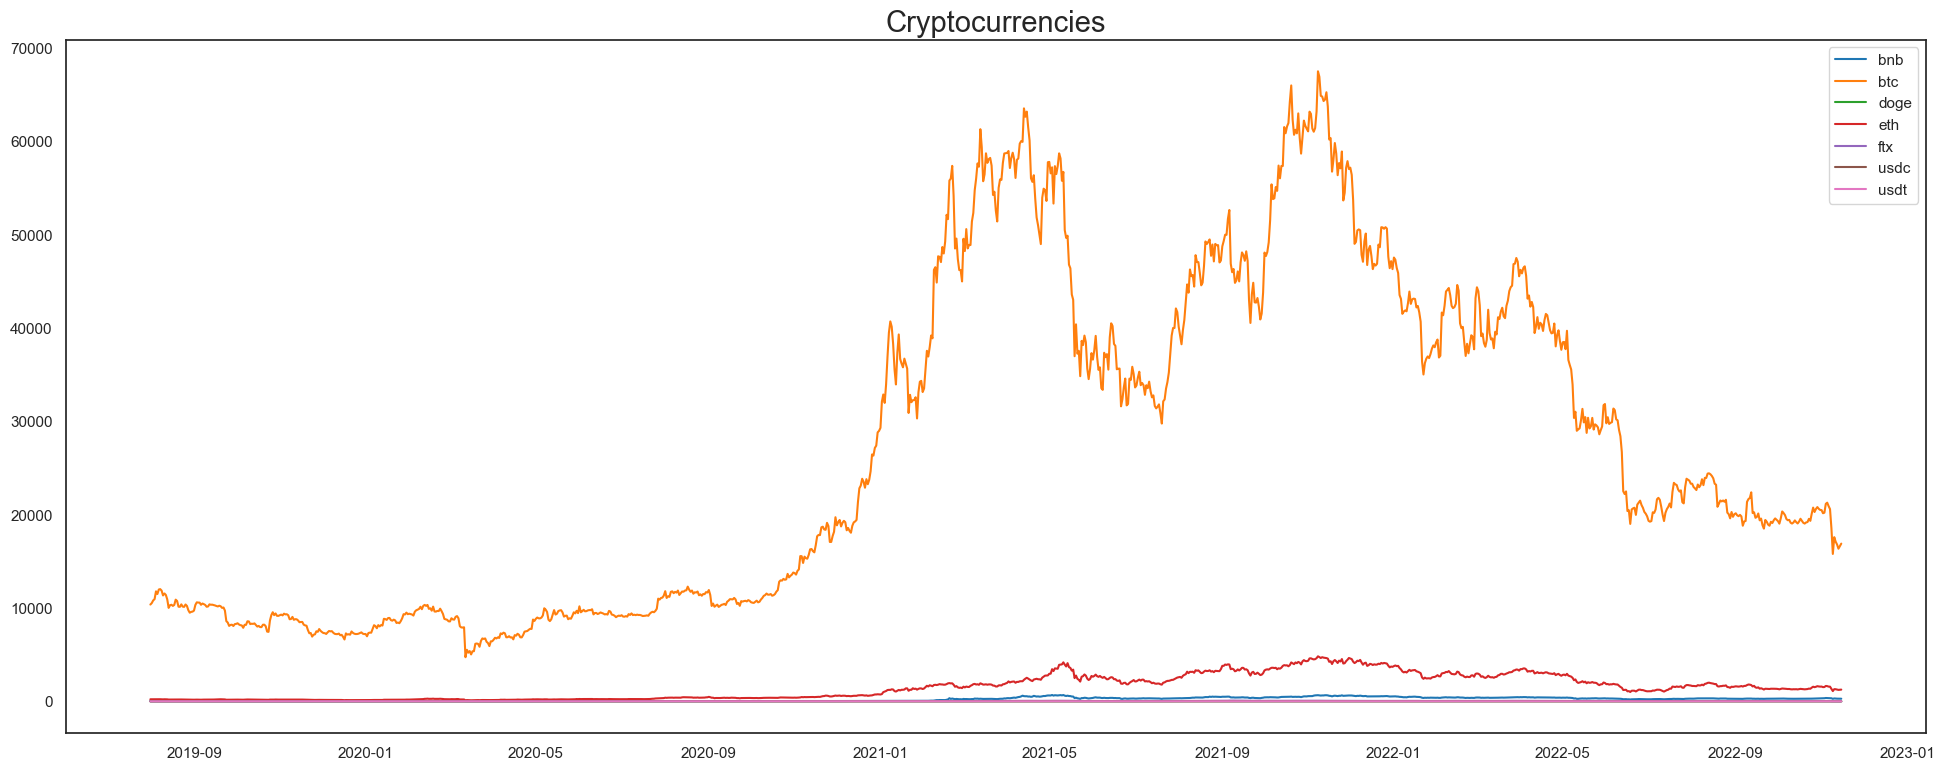

In [17]:
plt.figure(figsize=(24, 9))
for i in range(0, 7):
    plt.plot(coins.index, coins.iloc[:, i], label=coins.columns[i])

plt.title("Cryptocurrencies", fontsize=21)
plt.legend()
plt.show()

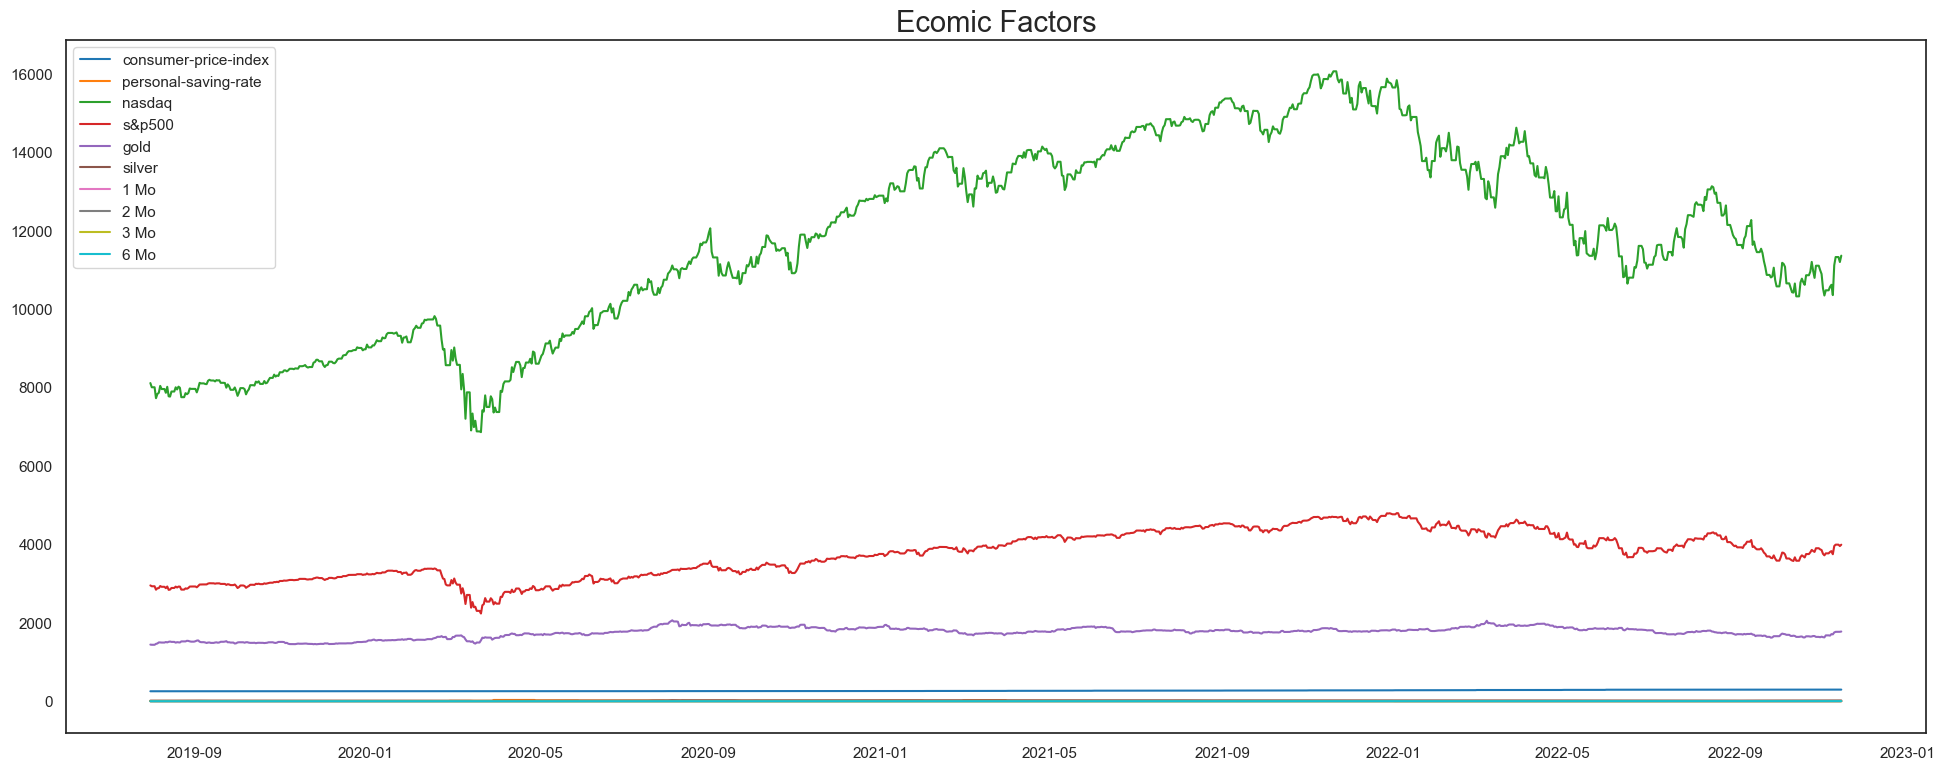

In [18]:
plt.figure(figsize=(24, 9))
for i in range(0, 10):
    plt.plot(factors.index, factors.iloc[:, i], label=factors.columns[i])

plt.title("Ecomic Factors", fontsize=21)
plt.legend()
plt.show()

# Creating Customize Index

In [19]:
result = []

# calculate the index value
for i in range(len(coins.columns)):
    coin = coins[coins.columns[i]] / len(coins.columns)
    result.append(coin)
# assign index value with date
ew_index = pd.DataFrame(1 + pd.DataFrame(pd.concat(result, axis=1)).sum(axis=1))
ew_index.set_axis([*ew_index.columns[:-1], "Index"], axis=1, inplace=True)

ew_index.tail(3)

,Index
Date,
2022-11-13,2233.135291
2022-11-14,2270.497737
2022-11-15,2304.661041


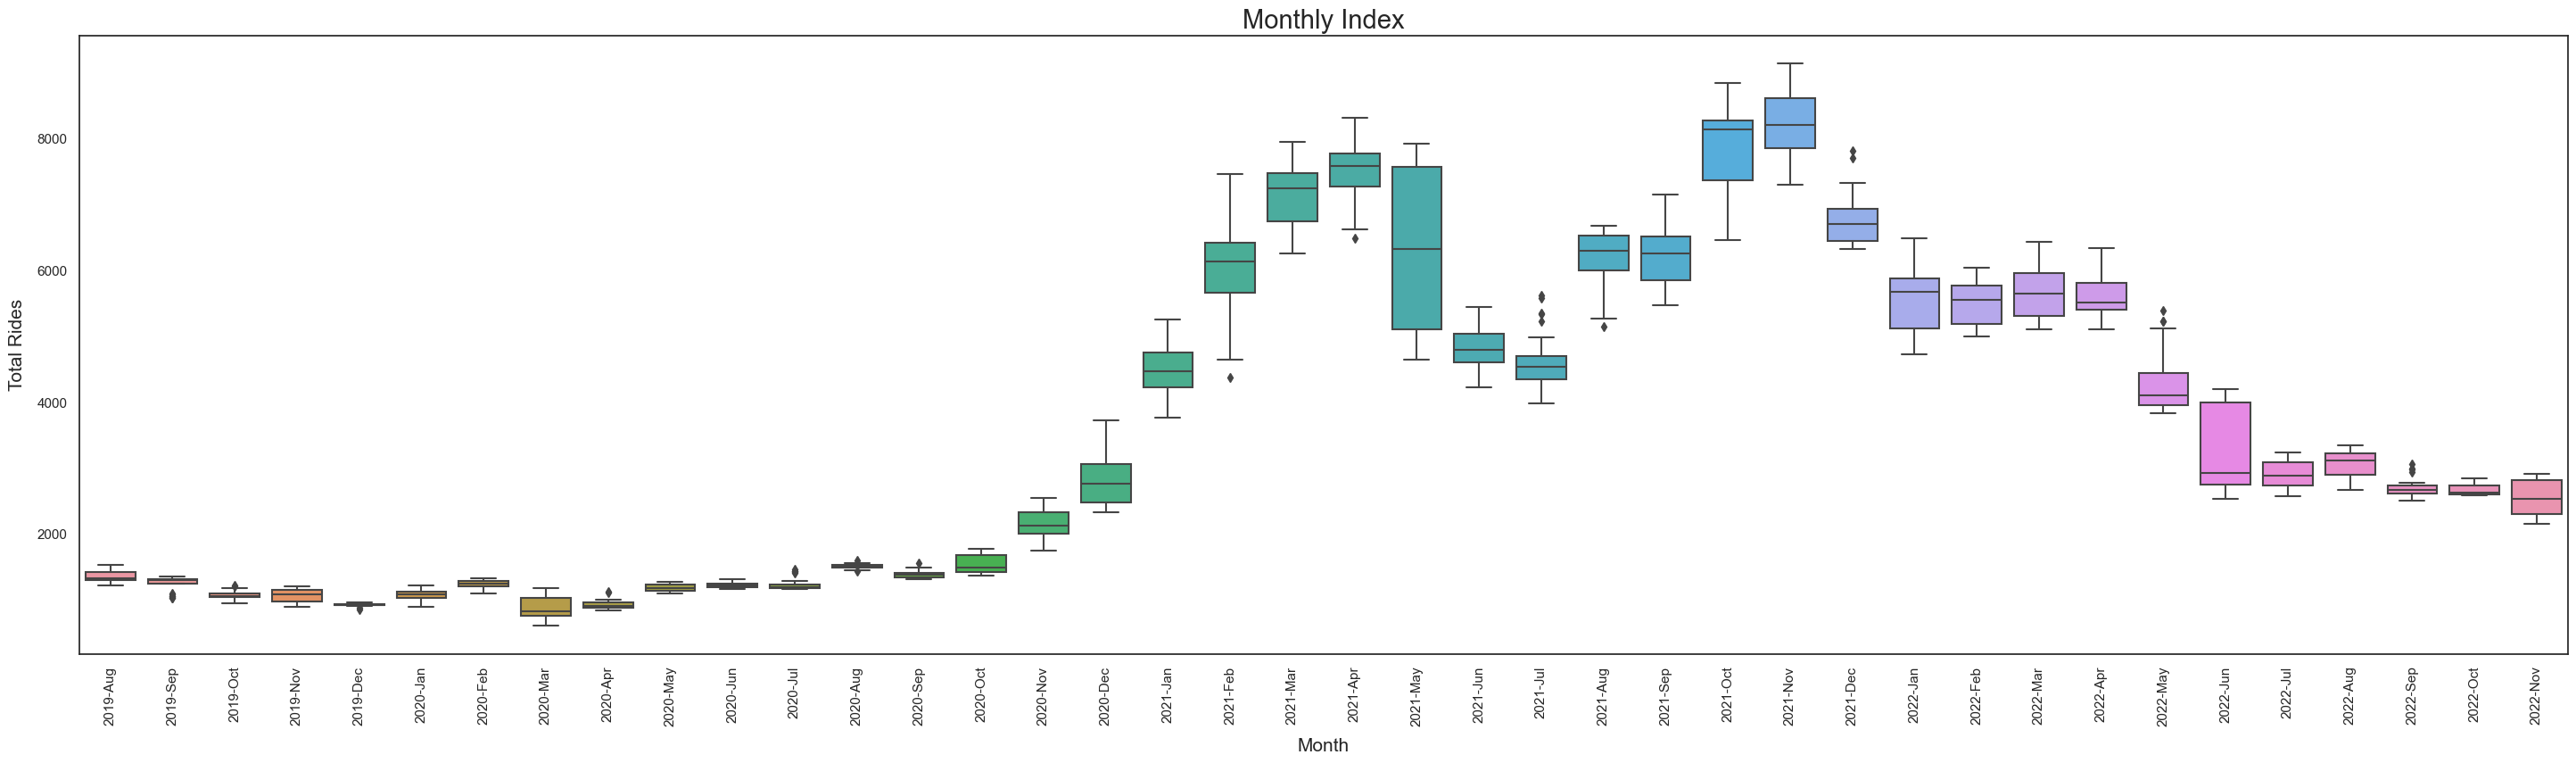

In [20]:
ts_fig, ts_ax = plt.subplots(figsize=(36, 9))
sns.boxplot(x=ew_index.index.strftime("%Y-%b"), y=ew_index.Index, ax=ts_ax)
ts_ax.set_xlabel("Month", labelpad=9, fontsize=15)
ts_ax.set_ylabel("Total Rides", labelpad=9, fontsize=15)
ts_ax.set_xticklabels(ts_ax.get_xticklabels(), rotation=90)
ts_ax.set_title("Monthly Index", fontsize=21)
plt.show()

In [21]:
data = factors.merge(ew_index, how="left", left_on="Date", right_on="Date")

In [22]:
data_nor = prepare_data(data)

data_nor.tail(3)

,consumer-price-index,personal-saving-rate,nasdaq,s&p500,gold,silver,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,Index
Date,,,,,,,,,,,,
2022-11-13,1.0,0.003247,0.485242,0.685979,0.529585,0.564939,0.981481,0.975610,0.986175,0.978261,0.955882,0.190801
2022-11-14,1.0,0.003247,0.471421,0.672037,0.531367,0.581829,0.984127,0.987805,1.000000,0.984783,0.964286,0.195183
2022-11-15,1.0,0.003247,0.489056,0.685510,0.541718,0.556785,0.997354,1.000000,0.993088,0.982609,0.957983,0.199191


# Time Series Forecasting

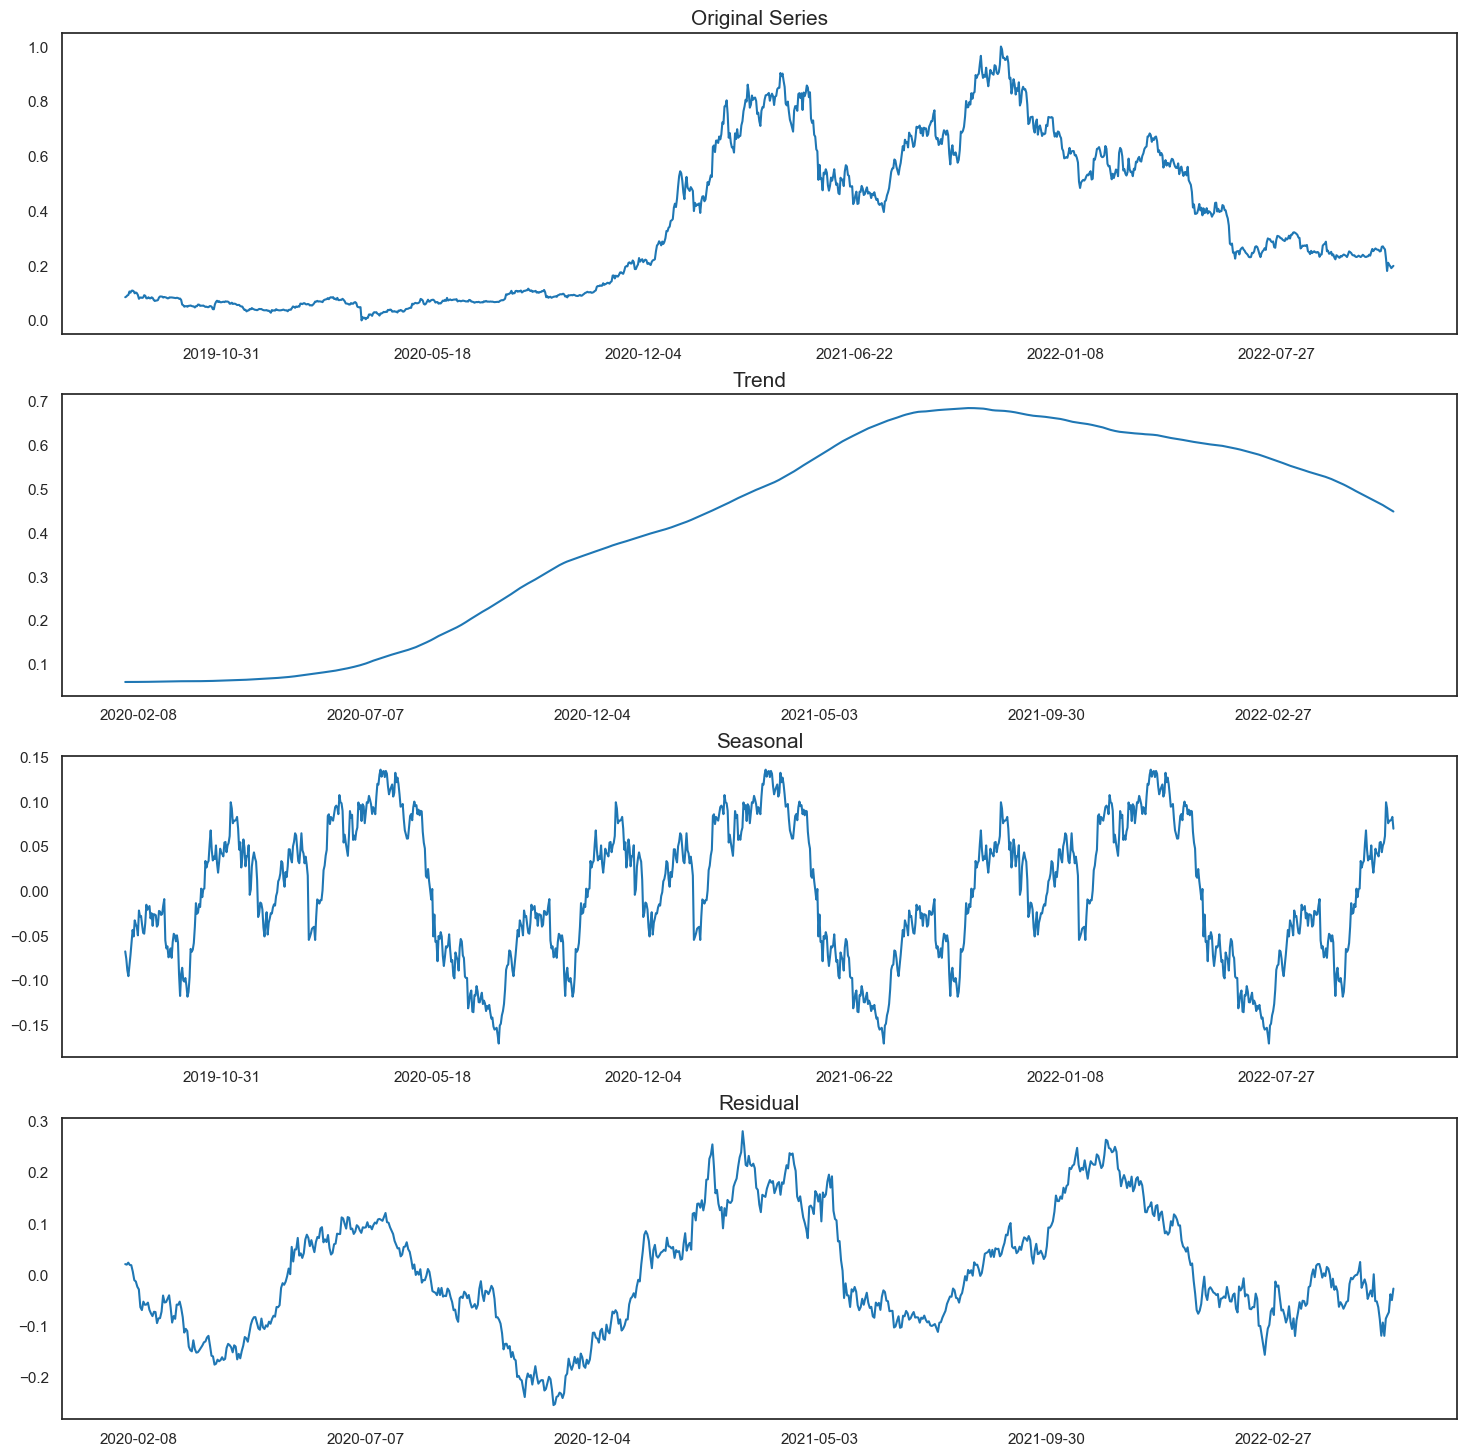

In [23]:
decompose(data_nor.Index, 365)

# Training and Testing Sets

In [26]:
X_train, X_test, y_train, y_test = time_series_split(data_nor, 0.9505)

# Implementing ARIMA Model

In [27]:
arima_param = auto_arima(y_train, start_p=1, d=1, start_q=1, max_p=5, max_q=5, trace=True, seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5753.803, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5756.672, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5755.802, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5755.797, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5758.612, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.878 seconds


In [28]:
algorithm = ARIMA(y_train, order=arima_param.get_params()["order"])
model = algorithm.fit()

In [29]:
# forecast the data
forecast = model.get_forecast(steps=len(y_test))
prediction = forecast.predicted_mean
ci = forecast.conf_int()

# check error rate
mse = mean_squared_error(y_test, prediction, squared=False)
rmse = mean_squared_error(y_test, prediction, squared=True)
print("The error rates of the ARIMA forecasting are: \nMSE = %f \nRMSE = %f" %(mse, rmse))

The error rates of the ARIMA forecasting are: 
MSE = 0.019946 
RMSE = 0.000398


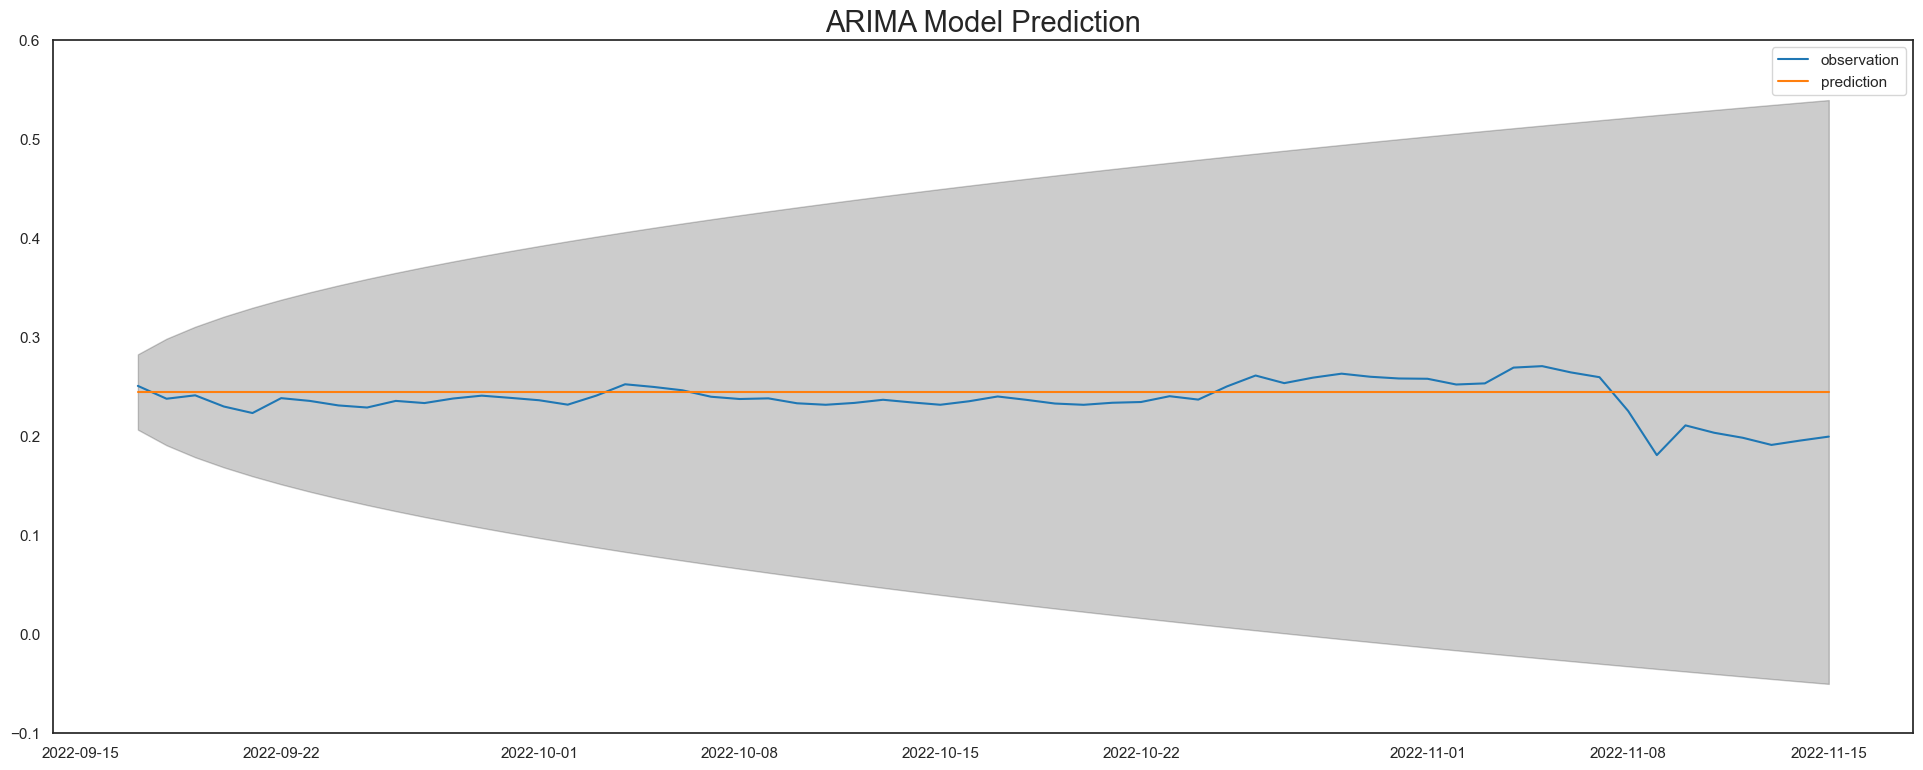

In [30]:
plt.figure(figsize=(24, 9))
plt.plot(y_test.index, y_test, label="observation")
plt.plot(prediction.index, prediction, label="prediction")
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color="k", alpha=0.2)
plt.ylim([-0.1, 0.6])
plt.title("ARIMA Model Prediction", fontsize=21)
plt.legend()
plt.show()

# Implementing SARIMAX Model

In [31]:
sarimax_param = auto_arima(y_train, exogenous=X_train, m=7, start_p=0, d=1, start_q=0, start_P=0, D=1, start_Q=0, max_p=3, max_q=1, max_P=3, max_Q=1, trace=True, seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-4875.606, Time=0.19 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-5232.037, Time=0.47 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.15 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-4874.647, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-5366.197, Time=1.06 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=-5467.987, Time=1.33 sec
 ARIMA(1,1,0)(3,1,1)[7]             : AIC=inf, Time=5.68 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=2.99 sec
 ARIMA(0,1,0)(3,1,0)[7]             : AIC=-5467.389, Time=0.49 sec
 ARIMA(2,1,0)(3,1,0)[7]             : AIC=-5466.161, Time=1.72 sec
 ARIMA(1,1,1)(3,1,0)[7]             : AIC=-5464.099, Time=2.44 sec
 ARIMA(0,1,1)(3,1,0)[7]             : AIC=-5467.917, Time=1.01 sec
 ARIMA(2,1,1)(3,1,0)[7]             : AIC=-5464.312, Time=2.48 sec
 ARIMA(1,1,0)(3,1,0)[7] intercept   : AIC=-5465.981, Time=2.89 sec

Best model:  ARIMA(1,1,0)(3,1,0)[7] 

In [32]:
algorithm = SARIMAX(endog=y_train, exog=X_train, order=sarimax_param.get_params()["order"], seasonal_order=sarimax_param.get_params()["seasonal_order"])
model = algorithm.fit(disp=False)

In [33]:
# forecast the data
forecast = model.get_prediction(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test, dynamic=True)
prediction = forecast.predicted_mean
ci = forecast.conf_int()

# check error rate
mse = mean_squared_error(y_test, prediction, squared=False)
rmse = mean_squared_error(y_test, prediction, squared=True)
print("The error rates of the SARIMAX forecasting are: \nMSE = %f \nRMSE = %f" %(mse, rmse))

The error rates of the SARIMAX forecasting are: 
MSE = 0.027621 
RMSE = 0.000763


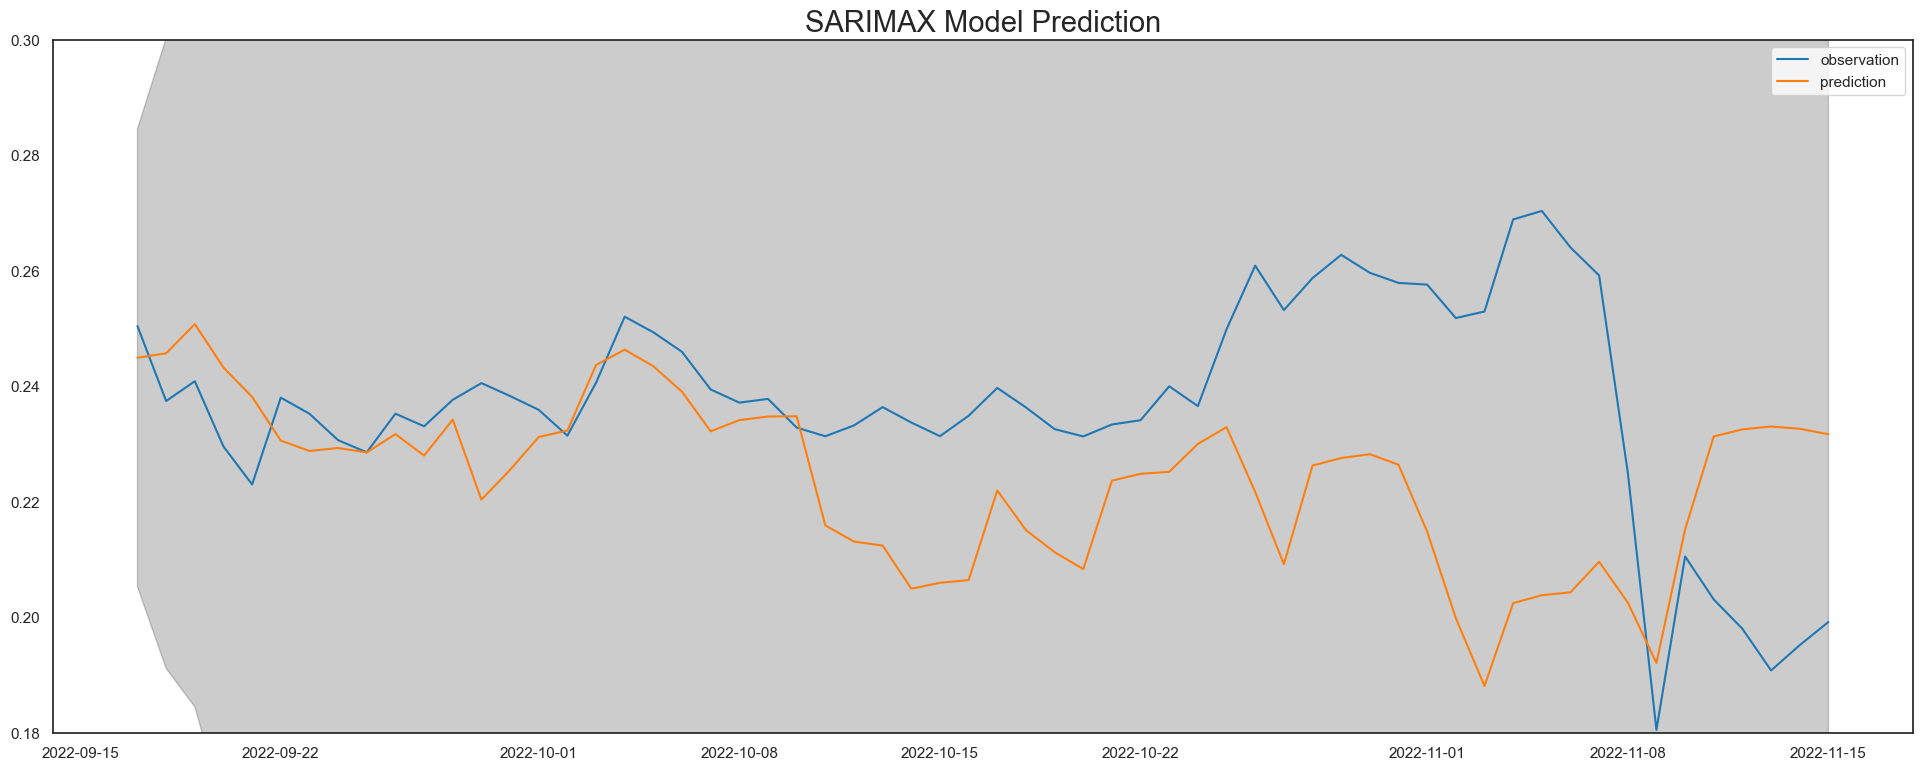

In [34]:
plt.figure(figsize=(24, 9))
plt.plot(y_test.index, y_test, label="observation")
plt.plot(prediction.index, prediction, label="prediction")
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color="k", alpha=0.2)
plt.ylim([0.18, 0.3])
plt.title("SARIMAX Model Prediction", fontsize=21)
plt.legend()
plt.show()

# Optional: Deeper Understanding of Data Preprocessing

# First, let us find out how many null values are in the crypto data.

In [35]:
cryptos.isnull().sum()

bnb     2573
btc        0
doge    1233
eth     1833
ftx     3287
usdc    2991
usdt    1614
xrp     1100
dtype: int64

In [37]:
find_first_date(cryptos)

In [38]:
cryptos = cryptos[start_date:]

cryptos.tail(3)

,bnb,btc,doge,eth,ftx,usdc,usdt,xrp
Date,,,,,,,,
2022-11-13,279.372157,16349.997597,0.084762,1223.796978,1.491613,1.00010,0.998967,0.340153
2022-11-14,278.798441,16630.637464,0.085818,1242.592693,1.493649,1.00000,0.999167,0.374665
2022-11-15,277.250100,16894.926500,0.086965,1252.796100,1.841371,0.99995,0.998983,0.388356


In [39]:
# set data to first date
predictor_variables = predictor_variables[start_date:]
# check for null
predictor_variables.isnull().sum()

consumer-price-index    1164
personal-saving-rate    1165
nasdaq                   372
s&p500                   372
gold                     344
silver                   345
1 Mo                     379
2 Mo                     379
3 Mo                     379
6 Mo                     379
1 Yr                     379
2 Yr                     379
3 Yr                     379
5 Yr                     379
7 Yr                     379
10 Yr                    379
20 Yr                    379
30 Yr                    379
4 Mo                    1184
dtype: int64

In [40]:
predictor_variables.drop(["4 Mo"], axis=1, inplace=True)

In [41]:
# fill missing datetime with previous day's values
predictor_variables = predictor_variables.reindex(pd.date_range(start_date, end_date)).reset_index().rename(columns={"index": "Date"})
predictor_variables = predictor_variables.groupby(predictor_variables["Date"].dt.time).ffill()
predictor_variables.set_index("Date", inplace=True)

predictor_variables.tail(3)

,consumer-price-index,personal-saving-rate,nasdaq,s&p500,gold,silver,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Date,,,,,,,,,,,,,,,,,,
2022-11-13,298.062,3.1,11323.33,3992.93,1770.69,21.68,3.71,4.00,4.28,4.52,4.59,4.34,4.17,3.95,3.89,3.82,4.24,4.03
2022-11-14,298.062,3.1,11196.22,3957.25,1771.80,21.97,3.72,4.05,4.34,4.55,4.63,4.40,4.24,4.00,3.95,3.88,4.28,4.07
2022-11-15,298.062,3.1,11358.41,3991.73,1778.25,21.54,3.77,4.10,4.31,4.54,4.60,4.37,4.17,3.93,3.88,3.80,4.20,3.98


In [42]:
# normalized the data with min-max scaling
data_nor = pd.DataFrame(MinMaxScaler().fit_transform(data)).assign(label=data.index)
data_nor.columns = data.columns.to_list() + ["Date"]
data_nor.set_index("Date", inplace=True)

data_nor.tail(3)

,consumer-price-index,personal-saving-rate,nasdaq,s&p500,gold,silver,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,Index
Date,,,,,,,,,,,,,,,,,,,
2022-11-13,1.0,0.003247,0.485242,0.685979,0.529585,0.564939,0.981481,0.975610,0.986175,0.978261,0.955882,0.917927,0.892544,0.882629,0.8825,0.884718,0.905914,0.891496,0.190801
2022-11-14,1.0,0.003247,0.471421,0.672037,0.531367,0.581829,0.984127,0.987805,1.000000,0.984783,0.964286,0.930886,0.907895,0.894366,0.8975,0.900804,0.916667,0.903226,0.195183
2022-11-15,1.0,0.003247,0.489056,0.685510,0.541718,0.556785,0.997354,1.000000,0.993088,0.982609,0.957983,0.924406,0.892544,0.877934,0.8800,0.879357,0.895161,0.876833,0.199191


In [43]:
data_nor.corr(method="pearson").style.background_gradient(cmap="coolwarm", axis=None).set_precision(2)

,consumer-price-index,personal-saving-rate,nasdaq,s&p500,gold,silver,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,Index
consumer-price-index,1.00,-0.70,0.46,0.66,0.31,0.16,0.33,0.40,0.45,0.56,0.64,0.72,0.77,0.82,0.83,0.83,0.86,0.80,0.42
personal-saving-rate,-0.70,1.00,-0.27,-0.49,0.01,-0.08,-0.45,-0.48,-0.50,-0.55,-0.60,-0.66,-0.69,-0.71,-0.72,-0.71,-0.69,-0.67,-0.23
nasdaq,0.46,-0.27,1.00,0.95,0.66,0.78,-0.49,-0.45,-0.42,-0.36,-0.29,-0.20,-0.14,-0.04,0.02,0.06,0.13,0.07,0.89
s&p500,0.66,-0.49,0.95,1.00,0.56,0.66,-0.28,-0.23,-0.19,-0.12,-0.04,0.06,0.13,0.23,0.28,0.32,0.37,0.31,0.87
gold,0.31,0.01,0.66,0.56,1.00,0.78,-0.59,-0.54,-0.50,-0.41,-0.32,-0.24,-0.21,-0.17,-0.15,-0.14,-0.07,-0.14,0.44
silver,0.16,-0.08,0.78,0.66,0.78,1.00,-0.54,-0.52,-0.50,-0.46,-0.41,-0.35,-0.31,-0.24,-0.19,-0.13,-0.05,-0.07,0.65
1 Mo,0.33,-0.45,-0.49,-0.28,-0.59,-0.54,1.00,0.99,0.99,0.95,0.91,0.83,0.80,0.75,0.73,0.71,0.66,0.71,-0.43
2 Mo,0.40,-0.48,-0.45,-0.23,-0.54,-0.52,0.99,1.00,1.00,0.98,0.94,0.88,0.85,0.80,0.78,0.76,0.72,0.76,-0.40
3 Mo,0.45,-0.50,-0.42,-0.19,-0.50,-0.50,0.99,1.00,1.00,0.99,0.96,0.91,0.88,0.84,0.81,0.79,0.75,0.79,-0.38
6 Mo,0.56,-0.55,-0.36,-0.12,-0.41,-0.46,0.95,0.98,0.99,1.00,0.99,0.95,0.93,0.90,0.87,0.85,0.82,0.84,-0.33


In [44]:
# we will remove the weak corellation (% between -0.2 to 0.2)
cor = data_nor.corr(method="pearson")
data_nor.drop(data_nor.columns[(cor.Index >= -0.2) & (cor.Index <= 0.2)], axis=1, inplace=True)

data_nor.tail(3)

,consumer-price-index,personal-saving-rate,nasdaq,s&p500,gold,silver,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,Index
Date,,,,,,,,,,,,
2022-11-13,1.0,0.003247,0.485242,0.685979,0.529585,0.564939,0.981481,0.975610,0.986175,0.978261,0.955882,0.190801
2022-11-14,1.0,0.003247,0.471421,0.672037,0.531367,0.581829,0.984127,0.987805,1.000000,0.984783,0.964286,0.195183
2022-11-15,1.0,0.003247,0.489056,0.685510,0.541718,0.556785,0.997354,1.000000,0.993088,0.982609,0.957983,0.199191


# Optional: Deeper Understanding of Time Series Forecasting

Original Time Series
ADF Statistic: -1.318854
p-value: 0.620503

First Order Differencing
ADF Statistic: -9.650688
p-value: 0.000000

Second Order Differencing
ADF Statistic: -12.401446
p-value: 0.000000



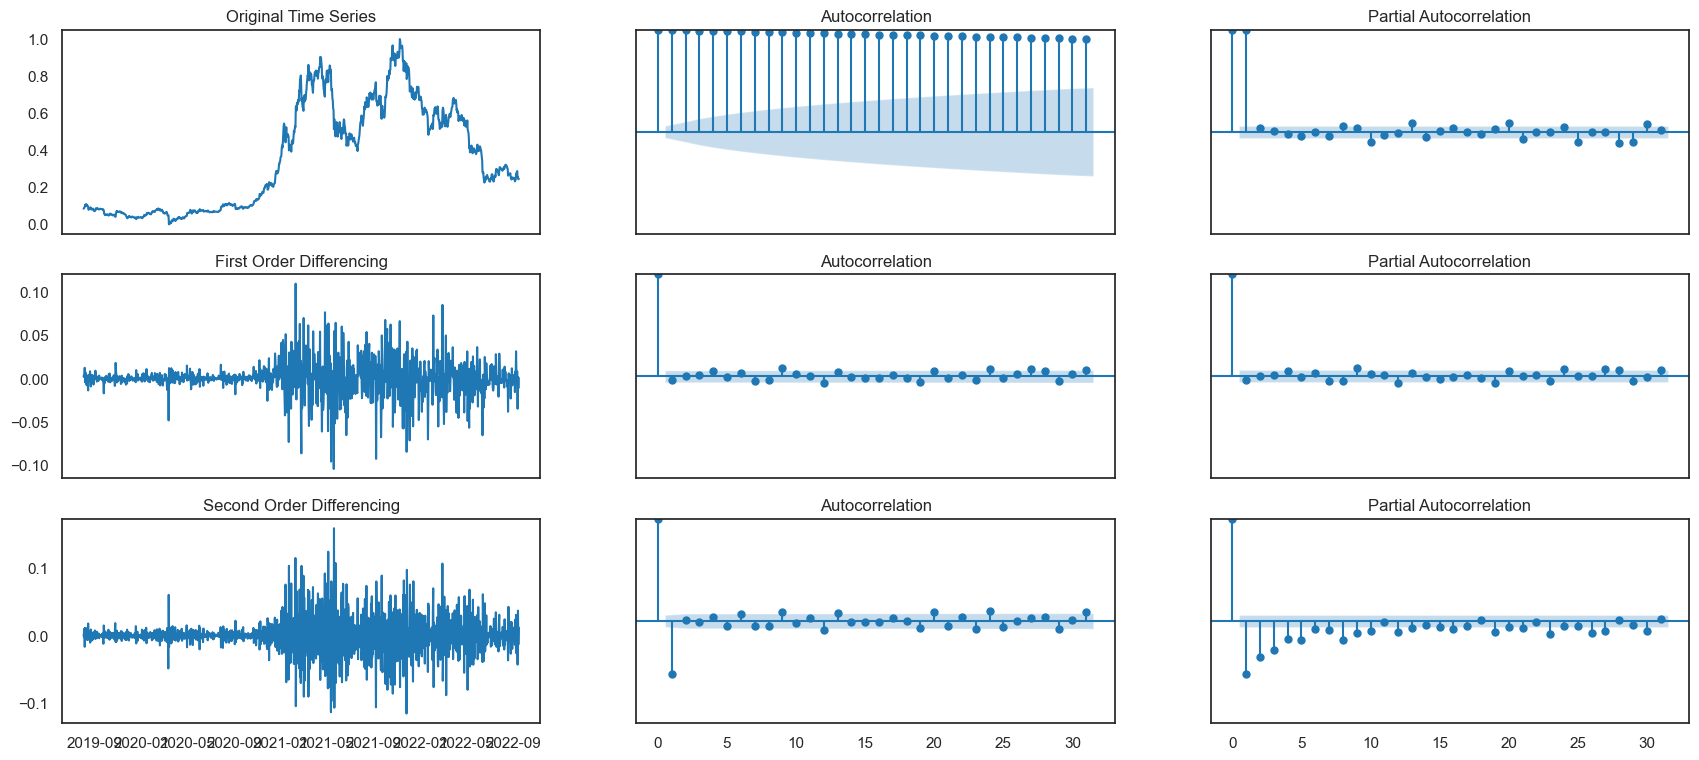

In [46]:
stationary(y_train)